# Using Athena in Jupyter notebook

In the previous [notebook](loading-to-athena.ipynb), we setup our data in Athena.  In this section, we will query the data via Jupyter notebook.  This will allow us to leverage Python's data query and analysis package for data exploration and analysis.  To connect our Athena instance, we will the [pyathenajdbc](https://pypi.org/project/PyAthenaJDBC/) module.

In [21]:
import contextlib
from pyathenajdbc import connect
from pyathenajdbc.util import as_pandas
import matplotlib.pyplot as plt
import pandas as pd
from functools import reduce

### Connect to Athena  

* Create a file containing your AWS credentials and save it `.creds/AWSCredentials.properties`. 
* The `AWSCredentials.properties` should contain the following:

```
[default]
accessKey:YourAccessKey
secretKey:YourSecretKey
```

* More info about AWS Credentials in the [AWS guides](https://docs.aws.amazon.com/general/latest/gr/aws-security-credentials.html).

In [4]:
%%time
conn = connect(credential_file='.creds/AWSCredentials.properties',
               s3_staging_dir='s3://dostsensor-db/',
               region_name='us-east-1')

CPU times: user 3.66 s, sys: 569 ms, total: 4.23 s
Wall time: 7.64 s


### Query data from Athena

Now that we are connected to Athena, we can start running simple queries and execute basic analysis.  We do this by creating standard SQL and load them as Pandas dataframes.  Let's start by counting all rows of each sensors available in Athena aggregated by week.

In [5]:
%%time
asg = pd.read_sql("""SELECT date_trunc('week', cast(time as timestamp)) as period, count(distinct(name)) as asg
                  FROM dostsensor.asg
                  GROUP BY 1
                  ORDER by 1 DESC;
                  """, conn)

CPU times: user 821 ms, sys: 85.9 ms, total: 907 ms
Wall time: 27.1 s


In [6]:
%%time
arg = pd.read_sql("""
                  SELECT date_trunc('week', cast(time as timestamp)) as period, count(distinct(name)) as arg
                  FROM dostsensor.arg
                  GROUP BY 1
                  ORDER by 1 DESC;
                  """, conn)

CPU times: user 863 ms, sys: 78.5 ms, total: 941 ms
Wall time: 53.1 s


In [7]:
%%time
aws = pd.read_sql("""
                  SELECT date_trunc('week', cast(time as timestamp)) as period, count(distinct(name)) as aws
                  FROM dostsensor.aws
                  GROUP BY 1
                  ORDER by 1 DESC;
                  """, conn)

CPU times: user 298 ms, sys: 27.5 ms, total: 325 ms
Wall time: 11.4 s


In [8]:
%%time
td = pd.read_sql("""
                  SELECT date_trunc('week', cast(time as timestamp)) as period, count(distinct(name)) as td
                  FROM dostsensor.td
                  GROUP BY 1
                  ORDER by 1 DESC
                  """, conn)

CPU times: user 390 ms, sys: 50.5 ms, total: 440 ms
Wall time: 40.4 s


### Merge all dataframes and display the plot

In [9]:
data_frames = [arg, asg, aws, td]
count_merged = reduce(lambda  left,right: pd.merge(left,right,on=['period'],
                                            how='outer'), data_frames)
count_merged.describe()


,arg,asg,aws,td
count,109.000000,108.000000,106.000000,101.0
mean,511.302752,269.379630,99.716981,274.0
std,181.002277,89.704991,36.579139,0.0
min,1.000000,1.000000,1.000000,274.0
25%,449.000000,229.000000,71.500000,274.0
50%,552.000000,289.500000,104.500000,274.0
75%,663.000000,340.250000,131.000000,274.0
max,686.000000,421.000000,187.000000,274.0


In [10]:
# Index data by timestamp (period)

count_merged['period'] = pd.to_datetime(count_merged['period'])
count_merged = count_merged.set_index(['period'])

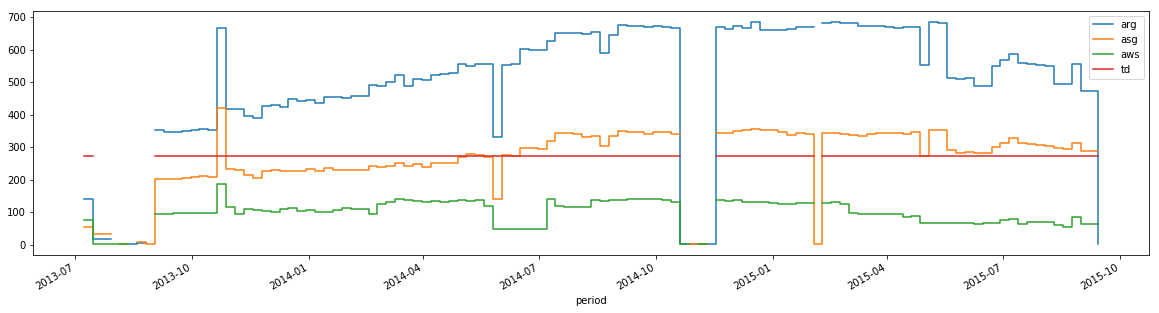

In [22]:
# Plot record count by sensor type.

count_merged.plot(drawstyle="steps-post", figsize=(20,5))

The most number of records came from the `arg` sensor.  For the years 2103-2014, DOST have installed a lot of `arg` sensors in response to the active DRR initiatives across the country.  

There are sporadic dips in our records maybe attributed to either downtime of the NOAH API or the logging instance we used to collect this data.  To be able to do time depedent analysis we should consider these gaps.

### Get data for specific stations

Let's look at the data for all water level monitoring stations (asg) on major tributaries of the Marikina river.  We will aggregate the data average by day.

In [12]:
%%time
marikina_wl = pd.read_sql("""
                  SELECT date_trunc('day', cast(time as timestamp)) as period, name, AVG(value) as value
                  FROM dostsensor.asg
                  WHERE name IN (
                  'metromanilastoninoastimarikinacity_wl',
                  'metromanilastonino_wl',
                  'metromanilatumana_wl',
                  'metromanilanangka_wl',
                  'metromanilatumanamarikinacity_wl',
                  'metromanilamodestabridgebrgyfortunemarikinacity_wl',
                  'rizalmontalban_wl')
                  GROUP BY 1,2
                  ORDER BY 1 DESC
                  """, conn)

CPU times: user 1.97 s, sys: 58.6 ms, total: 2.03 s
Wall time: 16.9 s


In [13]:
# Index data by day (period)

marikina_wl['period'] = pd.to_datetime(marikina_wl['period'])
marikina_wl1 = marikina_wl.set_index(['period'])
marikina_wl1.head()

,name,value
period,,
2015-08-31,metromanilamodestabridgebrgyfortunemarikinacit...,27.610794
2015-08-31,metromanilatumanamarikinacity_wl,13.446250
2015-08-30,metromanilastoninoastimarikinacity_wl,13.082692
2015-08-30,metromanilatumanamarikinacity_wl,13.395082
2015-08-30,metromanilamodestabridgebrgyfortunemarikinacit...,27.864667


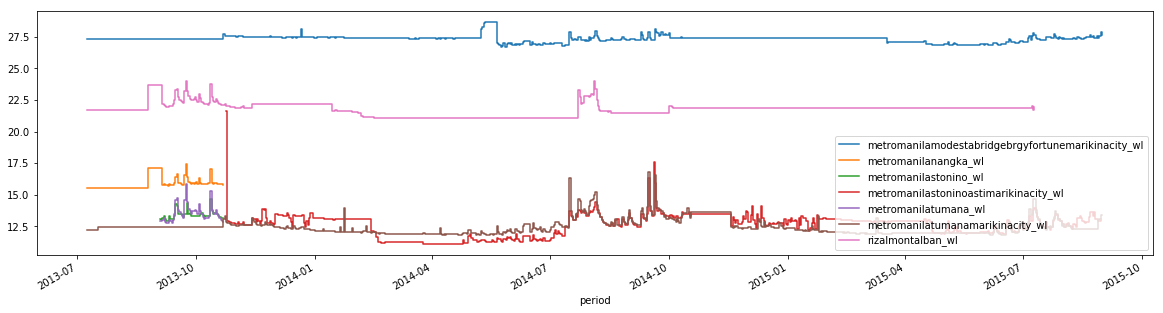

In [23]:
# Plot record count by station.

fig, ax = plt.subplots(figsize=(20,5))
for label, df in marikina_wl1.groupby('name'):
    df.value.plot(ax=ax, label=label, drawstyle="steps-post")
plt.legend(loc=4)

There are several periods when waterlevels increased significantly (Sep 2013, Aug 2014, Sep-Oct 2014, Aug 2105).  These events are attributed to the annual southwest monsoon cycle locally known as Habagat.

In this section, we connected Athena to Jupyter notebook and was able to run basic data query and plots.  In the next section, we will explore how we can use the data for in-depth data analysis of rainfall and its effects on stream water levels.